## Import Libraries

In [1]:
import nltk
import numpy as np
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import string
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers
# from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
# import os
import seaborn as sns
import pickle

nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abdulelah\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abdulelah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abdulelah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\abdulelah\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
DataSet = pd.read_csv("SPAM_OR_HAM.csv") #Reading the dataset

In [3]:
DataSet.head(20) # this function shows you the number of row that you want from the dataset

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [4]:
print(DataSet['Category'].unique()) 
DataSet["Category"].value_counts() #Category refers to the attribute name in the dataset

['ham' 'spam']


Category
ham     4823
spam     745
Name: count, dtype: int64

## Check Missing Data and Duplicates

In [5]:
print(DataSet.isnull().sum()) #this show the null varibles in the dataset
print("\n")
duplicatesDroped = len(DataSet) - len(DataSet.drop_duplicates())
print("Number of duplicates droped:" )
print(duplicatesDroped) #this shows numbers of duplicates is the dataset 
DataSet.drop_duplicates(inplace = True) # this removes any duplicates

Category    0
Message     0
dtype: int64


Number of duplicates droped:
415


## Data Visualization

<Axes: ylabel='count'>

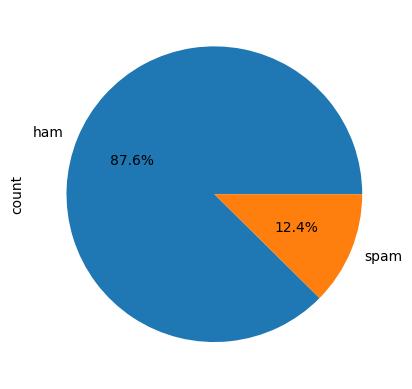

In [6]:
ratio_spam_and_ham = DataSet["Category"].value_counts()
ratio_spam_and_ham.plot.pie(autopct = '%1.1f%%')

# Preparing the corpus

In [7]:
def preprocess(text):
  #The re.sub(pat, replacement, str) function searches for all the instances of pattern in the given string, and replaces them.
  #The replacement string can include '\1', '\2' which refer to the text from group(1), group(2), and so on from the original matching text.
    text = text.lower()  #what this fucnction does is that it removes the unwanted charectes from the corpus to prepare
    text = re.sub(r'https?://\S+|www.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]+', ' ', text)
    text = re.sub(r'[0-9]', '', text)

    translator = str.maketrans("", "", string.punctuation)

    text = text.translate(translator) #The translate() method returns a string where some specified characters are replaced with the character described in a dictionary, or in a mapping table.
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words("english")]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = " ".join(words)
    return text

In [8]:
# Apply the preprocess function to the 'Message' column of the dataset using the map() function
DataSet["Message"] = DataSet.Message.map(preprocess) 

In [9]:
  #finding the maximum length of all the messages in the dataset
maxSeq = len(DataSet["Message"][0])
for i in range (0,len(DataSet["Message"])):
    try:
        cur = len(DataSet["Message"][i])
        if (cur > maxSeq):
            maxSeq = cur
    except:
        pass

In [10]:
from collections import Counter
# Define a function to count the occurrence of each word in a text column
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

# Use the counter_word() function to count the occurrence of each word in the 'Message' column of the dataset
counter = counter_word(DataSet.Message)

# Set the maximum number of words to the total number of unique words in the 'Message' column of the dataset
MAX_NUM_WORDS = len(counter)

# Set the maximum sequence length to the value of maxSeq
MAX_SEQUENCE_LENGTH = maxSeq

In [11]:
# Set the embedding dimension
EMBEDDING_DIM = 100

# Create a Tokenizer object with a maximum vocabulary size of MAX_NUM_WORDS
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)

# Fit the tokenizer on the text messages in the 'Message' column of the dataset
tokenizer.fit_on_texts(DataSet['Message'].values)

# Save the tokenizer object to a file using pickle
with open("tokenizer_SPAM.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
# Convert the text messages in the 'Message' column of the dataset to sequences of integers using the tokenizer
X = tokenizer.texts_to_sequences(DataSet['Message'].values)

# Pad the sequences to a fixed length of MAX_SEQUENCE_LENGTH with zeros
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Print the shape of the data tensor
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5153, 442)


In [13]:
from sklearn import preprocessing

# Create a LabelEncoder object
labelencoder = preprocessing.LabelEncoder()

# Encode the target labels with values between 0 and n_classes-1
DataSet['Category'] = labelencoder.fit_transform(DataSet['Category'])

# Extract the encoded target labels as a numpy array
Y = DataSet['Category'].values

# Print the shape of the label tensor
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (5153,)


In [14]:
from sklearn.model_selection import train_test_split
# test_size:the number that defines the size of the test set----random state: exposes a number of methods for generating random numbers drawn from a variety of probability distributions
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42) 
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3864, 442) (3864,)
(1289, 442) (1289,)



# Training the model 

In [15]:
# Create a sequential model
model = tensorflow.keras.models.Sequential() 

# Add an embedding layer to the model with the specified maximum number of words and embedding dimension
model.add(layers.Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))

# Add an LSTM layer to the model with 32 units
model.add(layers.LSTM(32))

# Add a dense output layer to the model with a sigmoid activation function
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss, the Adam optimizer, and accuracy as a metric
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print a summary of the model architecture
print(model.summary())

history = model.fit(X_train, Y_train, epochs=10, batch_size=64,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
 #the dataset is split into 20% 80% which mean 80% for traning and 20% for testing
 #epochs is the total number of iterations of all the training data in one cycle for training the machine learning model


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 442, 100)          707000    
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 724,057
Trainable params: 724,057
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
49/49 [==============================] - 9s 55ms/step - loss: 0.4146 - accuracy: 0.8570 - val_loss: 0.1944 - val_accuracy: 0.9237
Epoch 2/10
49/49 [==============================] - 2s 40ms/step - loss: 0.1205 - accuracy: 0.9676 - val_loss: 0.0869 - val_accuracy: 0.9767
Epoch 3/10
49/49 [=========

# Model Evaluation

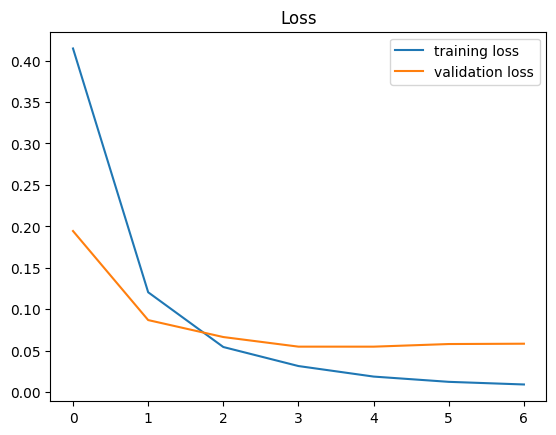

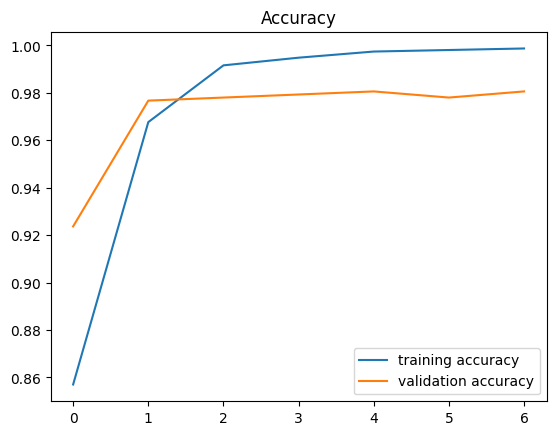

In [16]:
# Plot the training and validation loss
plt.title('Loss')
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

# Print a blank line for better readability
print("\n")

# Plot the training and validation accuracy
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [17]:
# Set the classification threshold
threshold_value = 0.5 

# Generate predicted labels for the test set using the trained model
predicted_labels = model.predict(X_test, verbose=2)

# Apply the classification threshold to the predicted labels to obtain binary predictions
binary_predictions = predicted_labels > threshold_value
binary_predictions = binary_predictions.astype(int)

# Import and use the classification report function from sklearn.metrics to calculate performance metrics
from sklearn.metrics import classification_report 
target_names = ['HAM', 'SPAM']
print(classification_report(Y_test, binary_predictions, target_names=target_names))

41/41 - 1s - 1s/epoch - 26ms/step
              precision    recall  f1-score   support

         HAM       0.99      0.99      0.99      1129
        SPAM       0.94      0.93      0.93       160

    accuracy                           0.98      1289
   macro avg       0.97      0.96      0.96      1289
weighted avg       0.98      0.98      0.98      1289



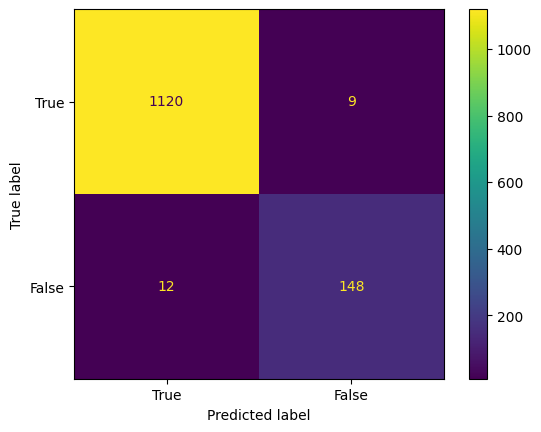

In [18]:
confusion_matrix = metrics.confusion_matrix(Y_test, binary_predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels = [True, False])

cm_display.plot()
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, binary_predictions)
cm_df = pd.DataFrame(cm, index = target_names, columns = target_names)
cm_df.head()

,HAM,SPAM
HAM,1120,9
SPAM,12,148


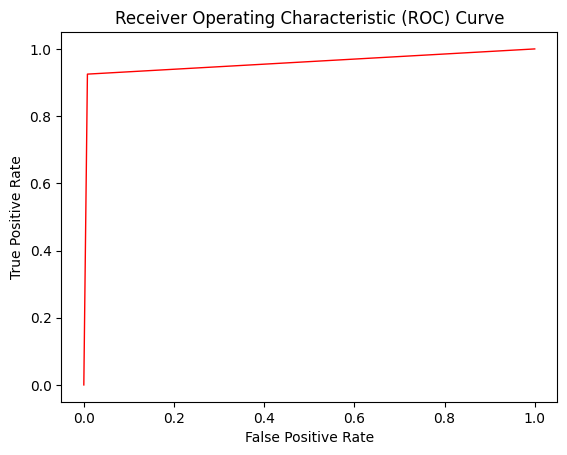

Area under the ROC curve: 0.958514171833481


In [20]:
# Define an array of cutoff values
cutoffs = np.linspace(0.0, 1.0, 100)

# Initialize empty lists to hold false positive rates and true positive rates
fpr_list = []
tpr_list = []

# Calculate the false positive rate, true positive rate, and cutoff values using the roc_curve function
fpr, tpr, _ = metrics.roc_curve(Y_test, binary_predictions, pos_label=1)

# Plot the ROC curve using the false positive rate and true positive rate values
plt.plot(fpr, tpr, color='red', linewidth=1.0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

# Calculate the area under the ROC curve using the roc_auc_score function
roc_auc = metrics.roc_auc_score(Y_test, binary_predictions)

# Print the area under the ROC curve
print("Area under the ROC curve:", roc_auc)

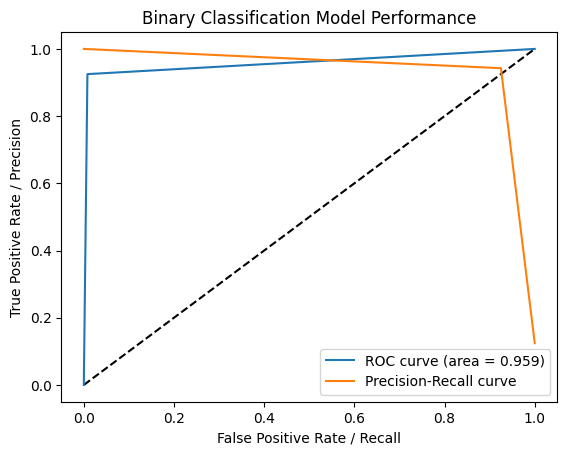

In [21]:
# Calculate the false positive rate, true positive rate, and thresholds using the roc_curve function
fpr, tpr, thresholds = metrics.roc_curve(Y_test, binary_predictions)

# Calculate the area under the ROC curve using the auc function
auc_score = metrics.auc(fpr, tpr)

# Calculate the precision, recall, and threshold values using the precision_recall_curve function
precision, recall, th = metrics.precision_recall_curve(Y_test, binary_predictions)

# Plot the ROC curve, Precision-Recall curve, and a diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc_score)
plt.plot(recall, precision, label='Precision-Recall curve')
plt.title('Binary Classification Model Performance')
plt.xlabel('False Positive Rate / Recall')
plt.ylabel('True Positive Rate / Precision')
plt.legend(loc='best')
plt.show()

## Save Model

In [22]:
model.save("./spamClassificationModel.h5") #this funcaion saves the model

## Model Testing

In [ ]:
import tensorflow as tf
import pickle

# Load the model
loaded_model = tf.keras.models.load_model("./spamClassificationModel.h5")

# Take input text from user
test_text = input("Enter the text message: ")
print(test_text)
# Preprocess the input text
test_text = preprocess(test_text) 
test_text = [test_text] 

# Load the tokenizer
with open("./tokenizer_SPAM.pickle", "rb") as handle:
    tokenizer = pickle.load(handle)

# Convert the input text to a sequence of integers
test_seq = tokenizer.texts_to_sequences(test_text)

# Pad the sequence to a fixed length
max_seq_length = loaded_model.input_shape[1]
test_seq = pad_sequences(test_seq, maxlen=max_seq_length)

# Apply the model to the input sequence
threshold = 0.07
binary_predictions = loaded_model.predict(test_seq)[0][0]
print(binary_predictions)

# Print the result
if binary_predictions > threshold:
    print("SPAM")
else:
    print("HAM")

: 